In [1]:
import cv2
import numpy as np
from pathlib import Path
from boxmot import DeepOCSORT, StrongSORT, BoTSORT
from ultralytics import YOLO
from pathlib import Path

In [2]:
def initialize_tracker(model_weights, device='cuda:0', fp16=True):
    """
    Initialize the DeepOCSORT tracker with the given model weights and device.
    """
    tracker = BoTSORT(
        model_weights=model_weights,
        device=device,
        fp16=fp16,
        match_thresh=0.9,
        proximity_thresh=0.1
    )
    return tracker

def initialize_yolo(model_path):
    """
    Initialize the YOLO object detector with the given model path.
    """
    yolov8 = YOLO(model_path)
    return yolov8

In [3]:
class Rect:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
    
    @property
    def bottom_center(self):
        return (int((self.x1 + self.x2) // 2), int(self.y2))
    
    @property
    def width(self):
        return self.x2 - self.x1

class Color:
    def __init__(self, b, g, r):
        self.b = b
        self.g = g
        self.r = r

    @property
    def bgr_tuple(self):
        return (self.b, self.g, self.r)

def draw_ellipse(image, rect, color, thickness=2):
    center = rect.bottom_center
    axes = (int(rect.width), int(0.35 * rect.width))
    cv2.ellipse(
        image,
        center,
        axes,
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image

def lab_to_rgb(lab_color):
    """
    Converts a single LAB color to RGB.
    """
    lab_image = np.array([[lab_color]], dtype=np.uint8)
    rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_Lab2RGB)
    return rgb_image[0][0]

def create_new_file(file_name):
    """
    Check if a file already exists, if it does append a number to the file
    The number increases if a file_"number" exists
    """
    if Path(file_name).is_file():
        file = file_name.split(".")[0]
        extension = file_name.split(".")[1]
        last_char = file[len(file) - 1]
        if last_char.isnumeric():
            last_char = str(int(last_char) + 1)
            new_file =  file[:-1] + last_char + "." + extension
        else:
            last_char = "_1"
            new_file =  file + last_char + "." + extension
        
        return create_new_file(new_file)
    else:
        return file_name

In [4]:
def plot_kmeans_clusters(player_mean_colors, labels):
    player_mean_colors = np.array([lab_to_rgb(color) for color in player_mean_colors])

    # Plotting the results (optional)
    plt.subplot(1, 2, 1)
    plt.scatter(player_mean_colors[:, 1], player_mean_colors[:, 2], c=player_mean_colors / 255.0)
    plt.title('Original Colors')

    plt.subplot(1, 2, 2)
    plt.scatter(player_mean_colors[labels == 0][:, 1], player_mean_colors[labels == 0][:, 2], c='blue', marker='o')
    plt.scatter(player_mean_colors[labels == 1][:, 1], player_mean_colors[labels == 1][:, 2], c='red', marker='x')
    plt.title('Clustered Colors')

    plt.show()
    
def home_away_color_ranges(home, away):
    # plot_lab_region(home[0], home[1])
    plot_lab_region(away[0], away[1])

    plt.figure(figsize=(10, 5))

    # Displaying the mask
    plt.subplot(1, 4, 1)
     # Plotting the most common color
    plt.imshow(cv2.cvtColor(home[0][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Home Lower")

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(home[1][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Home Upper")

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(away[0][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Away Lower")

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(away[1][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Away Upper")

    plt.show()

In [60]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sys
import sklearn
from collections import Counter


def adjust_bbox(image, bbox, height_fraction=(0.17, 0.5), width_fraction=(0.2, 0.2)):
    x1, y1, x2, y2 = bbox
    
    # Adjusting the bounding box to focus on the upper part
    height = y2 - y1
    width = x2 - x1
    
    new_y1 = y1 + int(height_fraction[0] * height)
    new_y2 = y1 + int(height_fraction[1] * height)
    new_x1 = x1 + int(width_fraction[0] * width)
    new_x2 = x2 - int(width_fraction[1] * width)

    adjusted_bbox = (new_x1, new_y1, new_x2, new_y2)
    roi = image[adjusted_bbox[1]:adjusted_bbox[3], adjusted_bbox[0]:adjusted_bbox[2]]

    return roi

def filter_out_color_LAB(roi_lab, lower_treshold, upper_treshold):
    # Getting the A channel and applying threshold
    a_channel = roi_lab[:,:,1]
    #127, 255
    _, mask = cv2.threshold(a_channel, lower_treshold, upper_treshold, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Using the mask to exclude green pixels in LAB
    roi_lab_filtered = roi_lab.copy()
    roi_lab_filtered[mask != 255] = 0
    return roi_lab_filtered

def get_color_histogram(image, bbox):
    """
    Get the color histogram within a specific portion of the bounding box in the HSV color space.
    """
    roi = adjust_bbox(image, bbox)
    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
    roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
    
    non_black_pixels = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
    color_counter = Counter(map(tuple, non_black_pixels))
    most_common_color = color_counter.most_common(1)[0][0]
        
    non_zero_subarrays = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
    
    hist = cv2.calcHist([roi_lab], [0, 1], None, [8, 8], [0, 180, 0, 256])
    
    cv2.normalize(hist, hist)
    
    return hist.flatten()

def get_mean_color(image, bbox):
    """
    Get the mean color within a specific portion of the bounding box in both RGB and LAB color spaces,
    excluding green pixels.
    """
    roi = adjust_bbox(image, bbox)
    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
    roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        
    non_zero_subarrays = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]

    # Calculate the mean of each channel
    if non_zero_subarrays.size > 0:
        mean_color_lab = non_zero_subarrays.mean(axis=0)
        
        
    color_counter = Counter(map(tuple, non_zero_subarrays))
    most_common_color_lab = np.array(color_counter.most_common(1)[0][0], dtype=np.uint8)

    most_common_color_bgr = cv2.cvtColor(np.array([[most_common_color_lab]], dtype=np.uint8), cv2.COLOR_Lab2BGR)[0][0]
    mean_color_bgr = cv2.cvtColor(np.array([[mean_color_lab]], dtype=np.uint8), cv2.COLOR_Lab2BGR)[0][0]
    return most_common_color_lab, mean_color_lab

def perform_kmeans_clustering(colors, initial_centroids, color_multiplier=4, max_iter=10, n_clusters=2):
    """
    Perform k-means clustering on the given color data.
    """
    colors = np.array(colors)
    
    colors[:,1:3] *= 4
    if len(initial_centroids) != 0:
        kmeans = KMeans(n_clusters=2, init=initial_centroids, random_state=0, n_init=1, max_iter=max_iter).fit(colors)
    else:
        kmeans = KMeans(n_clusters=2, random_state=0).fit(colors)
        initial_centroids = kmeans.cluster_centers_
        
    # Reassign labels based on the order of centroids
    sorted_idx = np.argsort(initial_centroids[:, 0])  # Assuming the 0th feature is a color channel like Red
    mapping = np.zeros(n_clusters, dtype=int)
    for i, idx in enumerate(sorted_idx):
        mapping[idx] = i

    consistent_labels = mapping[kmeans.labels_]
    
    return consistent_labels, initial_centroids

In [61]:
from scipy.spatial import distance
from scipy import stats
    
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



def plot_filtered_boxes(frame, boxes):
    plt.figure(figsize=(12, len(boxes) * 4))
    
    for i, box in enumerate(boxes):
        # Apply the ROI adjustment and color filtering
        roi = adjust_bbox(frame, box)
        roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
        roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        non_zero_colors = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]

        plt.subplot(len(boxes), 2, i * 2 + 1)
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Box {i+1}")

        plt.subplot(len(boxes), 2, i * 2 + 2)
        plt.imshow(cv2.cvtColor(roi_lab_filtered, cv2.COLOR_Lab2RGB))
        plt.title(f"Filtered Box {i+1}")
        
    plt.show()

def compute_common_color_cluster_and_range(frame, boxes, num_clusters=2, delta=10):
    colors = []
    for box in boxes:
        roi = adjust_bbox(frame, box)
        roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
        roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        non_zero_colors = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
        colors.extend(non_zero_colors)

    if len(colors) == 0:
        print("All colors are filtered out.")
        return None, None

    # Applying K-means clustering to group colors
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(colors)
    cluster_centers = kmeans.cluster_centers_.astype(int)

    # Getting the most common cluster center (centroid)
    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    most_common_cluster = cluster_centers[labels[np.argmax(counts)]]

    # Compute the color range
    lower_bound = np.clip(most_common_cluster - delta, 0, 255)
    upper_bound = np.clip(most_common_cluster + delta, 0, 255)

    # Plotting the most common color cluster center
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(most_common_cluster[np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Most Common Cluster Center")
    plt.axis('off')

    # Plotting colors within the range
    plt.subplot(1, 2, 2)
    for i in range(5):
        sample_color = np.random.randint(lower_bound, upper_bound+1)
        plt.imshow(cv2.cvtColor(sample_color[np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
        plt.title("Colors Within Range")
        plt.axis('off')

    plt.show()

    return lower_bound, upper_bound    
    
def compute_common_color_and_range(frame, boxes, delta=10):
    colors = []
    for box in boxes:
        roi = adjust_bbox(frame, box)
        roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
        roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        non_zero_colors = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
        colors.extend(non_zero_colors)

    if len(colors) == 0:
        print("All colors are filtered out.")
        return None, None

    color_counter = Counter(map(tuple, colors))
    most_common_color = np.array(color_counter.most_common(1)[0][0], dtype=np.uint8)

    # Compute the color range
    lower_bound = most_common_color - delta
    upper_bound = most_common_color + delta
    
    # Ensure the bounds are valid
    if np.any(upper_bound < lower_bound):
        print("Invalid color range corrected.")
        lower_bound = most_common_color
        upper_bound = most_common_color
    
    lower_bound = np.clip(lower_bound, 0, 255)
    upper_bound = np.clip(upper_bound, 0, 255)

    # Plotting the most common color
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(most_common_color[np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Most Common Color")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    for i in range(5):
        sample_color = np.random.randint(lower_bound, upper_bound + 1, size=(1,1,3))
        plt.imshow(cv2.cvtColor(sample_color.astype(np.uint8), cv2.COLOR_Lab2RGB))
        plt.axis('off')

    return lower_bound, upper_bound


def nearest_points(centroids, data_points, n):
    # Calculate the distances between each data point and each centroid
    distances = distance.cdist(data_points, centroids, 'euclidean')
    
    # Get the n smallest distances' indices for each centroid
    nearest_indices = np.argsort(distances, axis=0)[:n]
    
    # Creating a dictionary to hold the indices of the nearest points for each centroid
    nearest_per_centroid = {i: nearest_indices[:, i].tolist() for i in range(centroids.shape[0])}

    return nearest_per_centroid


def compute_jersey_colors(first_frame, dets, bounding_boxes, classes, color_multiplier=4):
    # get_mean_color returns a tuple, 0 is most common color, 1 is mean color
    class_1_boxes = [bounding_box for bounding_box, cls in zip(bounding_boxes, classes) if cls == 1]
    colors_bounding_boxes = [(get_mean_color(first_frame, bounding_box)[1], bounding_box) for bounding_box in class_1_boxes]
    
    mean_colors = []
    for color_bbox in colors_bounding_boxes:
        mean_colors.append(color_bbox[0])
    
    initial_centroids = []
    mean_colors = np.array(mean_colors)
    label_clusters, centroids = perform_kmeans_clustering(mean_colors, initial_centroids, color_multiplier=color_multiplier)
    clustered_points = mean_colors.copy()
    clustered_points[:,1:3] *= color_multiplier
    
    close_points = nearest_points(centroids, clustered_points, 4)
    
    centroid_1_boxes = [class_1_boxes[i] for i in close_points[0]]
    centroid_2_boxes = [class_1_boxes[i] for i in close_points[1]]
    
    
    #plot_filtered_boxes(first_frame, centroid_1_boxes)
    #plot_filtered_boxes(first_frame, centroid_2_boxes)
    print("first")
    home1 = compute_common_color_cluster_and_range(first_frame, centroid_1_boxes)
    home = compute_common_color_and_range(first_frame, centroid_1_boxes)

    print("second")
    away1 = compute_common_color_cluster_and_range(first_frame, centroid_2_boxes)
    away = compute_common_color_and_range(first_frame, centroid_2_boxes)


    print("Most Dominant Color (in LAB):", away1)
    return (home, away)
    

def plot_lab_region(lower_bound, upper_bound):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Define the vertices of the region
    # Each vertex is a combination of the lower and upper values for L, a, and b
    vertices = [
        [lower_bound[0], lower_bound[1], lower_bound[2]],
        [upper_bound[0], lower_bound[1], lower_bound[2]],
        [upper_bound[0], upper_bound[1], lower_bound[2]],
        [lower_bound[0], upper_bound[1], lower_bound[2]],
        [lower_bound[0], lower_bound[1], upper_bound[2]],
        [upper_bound[0], lower_bound[1], upper_bound[2]],
        [upper_bound[0], upper_bound[1], upper_bound[2]],
        [lower_bound[0], upper_bound[1], upper_bound[2]]
    ]
    
    vertices = np.array(vertices)
    
    # Define the vertices that compose each of the 6 faces of the region
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],
        [vertices[4], vertices[5], vertices[6], vertices[7]], 
        [vertices[0], vertices[1], vertices[5], vertices[4]], 
        [vertices[1], vertices[2], vertices[6], vertices[5]],
        [vertices[2], vertices[3], vertices[7], vertices[6]],
        [vertices[3], vertices[0], vertices[4], vertices[7]]
    ]
    
    # Draw the faces
    ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='black', alpha=.25))
    
    ax.set_xlabel('L*')
    ax.set_ylabel('a*')
    ax.set_zlabel('b*')
    ax.set_xlim([0, 255])
    ax.set_ylim([-255, 255])
    ax.set_zlim([-255, 255])
    plt.show()

        
def get_team_belonging(image, bounding_box, home_color, away_color, should_plot=False):
    #blur_kernel_size = (2,2)
    #image = cv2.blur(image, blur_kernel_size)
    roi = adjust_bbox(image, bounding_box)
    
    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
    
    roi_lab_away = roi_lab.copy()
    roi_lab_referee = roi_lab.copy()
    
    lower_blue = np.array([100, 50, 50])
    upper_blue = np.array([140, 255, 255])
    
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 50, 255])
    
    
    mask_home = cv2.inRange(roi_lab, home_color[0], home_color[1])
    #mask_home = cv2.inRange(roi_lab, lower_blue, upper_blue)
    result_home = cv2.bitwise_and(roi_lab, roi_lab, mask=mask_home)
    count_home = cv2.countNonZero(mask_home)
    
    mask_away = cv2.inRange(roi_lab_away, away_color[0], away_color[1])
    #mask_away = cv2.inRange(roi_lab_away, lower_white, upper_white)
    result_away = cv2.bitwise_and(roi_lab_away, roi_lab_away, mask=mask_away)
    count_away = cv2.countNonZero(mask_away)
    
    if should_plot:
        plt.figure(figsize=(10, 5))
        # Displaying the mask
        plt.subplot(1, 5, 1)
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title("Result")

        plt.subplot(1, 5, 2)
        plt.imshow(mask_home, cmap='gray')
        plt.title("Mask Home")

        # Displaying the result
        plt.subplot(1, 5, 3)
        plt.imshow(cv2.cvtColor(result_home, cv2.COLOR_HSV2RGB))
        plt.title("Result Home")

        plt.subplot(1, 5, 4)
        plt.imshow(mask_away, cmap='gray')
        plt.title("Mask Away")

        # Displaying the result
        plt.subplot(1, 5, 5)
        plt.imshow(cv2.cvtColor(result_away, cv2.COLOR_HSV2RGB))
        plt.title("Result Away")

        plt.show()
        
        
    team = -1
    
    if count_away > count_home:
        team = 1
        print("Away team")
    else:
        print("Home team")
        team = 0
        
    return team

In [62]:
import os
import cv2
import zipfile

# Function to get unique colors for each class id
def get_color(cls_id):
    np.random.seed(cls_id)
    return tuple(np.random.randint(0, 255, 3).tolist())

def split_ball_players(detections):
    dets = []
    ball = np.array([])
    highest_conf = 0

    for bounding_boxes in detections:
        if bounding_boxes[-1:] != 0:
            dets.append(bounding_boxes)
        if bounding_boxes[5] == 0:
            if bounding_boxes[4] > highest_conf:
                highest_conf = bounding_boxes[4]
                ball = bounding_boxes


    dets = np.array(dets)
    
    return dets, ball

def draw_on_frame(image, xyxys, ids, clss, labels, ball):
    thickness = 2
    fontscale = 0.5

    
    for xyxy, id, cls, label in zip(xyxys, ids, clss, labels):
        # Convert bounding box coordinates to Rect object
        rect = Rect(xyxy[0], xyxy[1], xyxy[2], xyxy[3])
        if cls == 1:
            cls = cls

        # Get a unique color for each class
        color = Color(*get_color(cls))

        # Draw an ellipse at the bottom of the bounding box
        draw_ellipse(image, rect, color, thickness)

        # Place ID text just above the ellipse
        cv2.putText(
            image,
            f'{id}',
            (rect.bottom_center[0] - 10, rect.bottom_center[1] - int(0.35 * rect.width) - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontscale,
            color.bgr_tuple,
            thickness
        )
    if len(ball) != 0:
        rect = Rect(int(ball[0]), int(ball[1]), int(ball[2]), int(ball[3]))
        # Get a unique color for each class
        color = Color(*get_color(0))

        # Draw an ellipse at the bottom of the bounding box
        draw_ellipse(image, rect, color, thickness)
        id = -1
        # Place ID text just above the ellipse
        cv2.putText(
            image,
            "-1",
            (rect.bottom_center[0] - 10, rect.bottom_center[1] - int(0.35 * rect.width) - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontscale,
            color.bgr_tuple,
            thickness
        )
        
        
def save_frame_as_image(frame, output_folder, frame_id):
    """Save the current frame as an image."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    filename = os.path.join(output_folder, f"{frame_id:06}.jpg")
    print("Saved: " + filename)
    cv2.imwrite(filename, frame)

def write_labels_txt(class_names, filepath):
    """Write class names to labels.txt."""
    with open(filepath, "w") as f:
        for name in class_names:
            f.write(name + "\n")

def export_to_mot_format(frames, track_ids, bboxes, class_ids, filepath):
    """Write the tracking results into gt.txt in the MOT format."""
    with open(filepath, 'w') as f:
        for frame_num, track_id, bbox, class_id in zip(frames, track_ids, bboxes, class_ids):
            x1, y1, x2, y2 = bbox
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            w = x2 - x1
            h = y2 - y1
            f.write(f"{frame_num},{track_id},{x1},{y1},{w},{h},1,{class_id},0.86014\n")


In [63]:
def process_video(input_file, output_file, tracker, yolov8, do_kmeans, conf=0.8, should_plot=False, class_names=None):
    """
    Process the input video, perform object detection and tracking, and save the results to the output video.
    """
    input_video = cv2.VideoCapture(input_file)
    width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = input_video.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
  
    initial_centroids = []
    counter = 1
    while True:
        print(counter)
        ret, image = input_video.read()
        if not ret:
            break
        
       
        predicted = yolov8.predict(image, conf=conf)
        detections = predicted[0].boxes.data.cpu().numpy()
        
        # Split the ball detections and player detections into two arrays
        # This ensures the labels are correct when doing team assignment
        # and that we only get 1 ball in each frame
        dets, ball = split_ball_players(detections)
        
        tracks = tracker.update(dets, image)
        
        # Set im = image so we can do transforms on the image for better color identification
        # Without altering the original image so when writing the video it looks the same
        #im = cv2.addWeighted(image, 0.75, image, 0.5, 0)
        im = image
        
        if tracks.size > 0:  # Check if tracks is not empty
            xyxys = tracks[:, 0:4].astype('int')
            ids = tracks[:, 4].astype('int')
            clss = tracks[:, 6].astype('int')
        else:
            print("Tracks is empty or not in expected format.")

        if(counter == 1):
            home, away = compute_jersey_colors(im, dets, xyxys, clss)
            
            if should_plot:
                home_away_color_ranges(home, away)
            
            
        if tracks.shape[0] != 0:
            player_mean_colors = [get_mean_color(im, xyxy)[1] for xyxy, cls in zip(xyxys, clss) if cls == 1]
            #player_mean_colors = [get_color_histogram(im, xyxy) for xyxy, cls in zip(xyxys, clss) if cls == 1]
            
            if(len(initial_centroids) == 0):
                labels, initial_centroids = perform_kmeans_clustering(player_mean_colors, initial_centroids)

            else:
                if do_kmeans:
                    labels = perform_kmeans_clustering(player_mean_colors, initial_centroids)[0]
                else:
                    labels = [get_team_belonging(im, xyxy, home, away) for xyxy, cls in zip(xyxys, clss) if cls == 1]
            
            if should_plot:
                plot_kmeans_clusters(player_mean_colors, labels)   
    
            draw_on_frame(image, xyxys, ids, clss, labels, ball)

        out.write(image)
        counter += 1
        
        
    input_video.release()
    out.release()
    cv2.destroyAllWindows()


2023-11-14 13:42:01.936 | SUCCESS  | boxmot.appearance.reid_model_factory:load_pretrained_weights:207 - Successfully loaded pretrained weights from "osnet_x1_0_market1501.pt"


Tracking output: videos/30sec_BODO_tracking_output_test_18.mp4
1



0: 1088x1920 1 ball, 22 players, 30.5ms
Speed: 7.0ms preprocess, 30.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


first


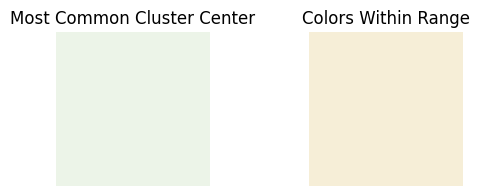

Invalid color range corrected.
second


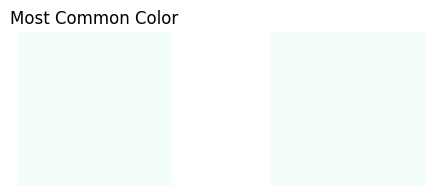

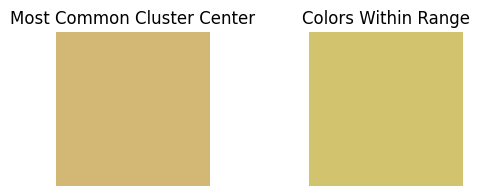

Most Dominant Color (in LAB): (array([182, 119, 155]), array([202, 139, 175]))



0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 7.0ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.5ms
Speed: 6.9ms preprocess, 30.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


2
3



0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 8.1ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.9ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


4
5



0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.8ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.2ms
Speed: 11.2ms preprocess, 30.2ms inference, 1.8ms postprocess per image at shape (1, 3, 1088, 1920)


6
7



0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.9ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.8ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


8
9



0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.8ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.4ms
Speed: 12.3ms preprocess, 30.4ms inference, 2.2ms postprocess per image at shape (1, 3, 1088, 1920)


10
11



0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 7.7ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.9ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


12
13



0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.8ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.9ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 1088, 1920)


14
15



0: 1088x1920 1 ball, 22 players, 30.2ms
Speed: 9.5ms preprocess, 30.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.9ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


16
17



0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.9ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.9ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


18
19



0: 1088x1920 1 ball, 22 players, 30.2ms
Speed: 7.8ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.9ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


20
21



0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.9ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.9ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


22
23



0: 1088x1920 1 ball, 22 players, 30.3ms
Speed: 12.7ms preprocess, 30.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.9ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


24
25



0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.8ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.8ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


26
27



0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.9ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)



28
29


0: 1088x1920 1 ball, 22 players, 30.2ms
Speed: 7.2ms preprocess, 30.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.9ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.8ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


30
31



0: 1088x1920 1 ball, 22 players, 30.1ms
Speed: 6.8ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


32


KeyboardInterrupt: 

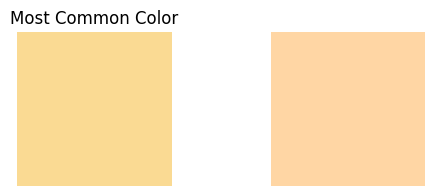

In [64]:
from pathlib import Path
import warnings
import time

warnings.filterwarnings("ignore")
model_weights = Path('osnet_x1_0_market1501.pt')
yolo_model_path = 'runs/detect/trackingAnnotations/weights/best.pt'
input_video_file = "videos/30sec_BODO.mp4"
output_video_name = create_new_file(input_video_file.split(".")[0] + "_tracking_output_test.mp4")

print("Tracking output: " + output_video_name)
output_video_file = output_video_name

# home_team_color="white"
# away_team_color="blue"

tracker = initialize_tracker(model_weights)
yolov8 = initialize_yolo(yolo_model_path)

class_names = ["player", "ball"] 

start_time = time.time()
process_video(input_video_file, output_video_file, tracker, yolov8, do_kmeans=True, should_plot=False, class_names=class_names)
end_time = time.time()

execution_time = end_time - start_time

print(f"Time taken to process video: {execution_time} seconds")

In [11]:
import zipfile
with zipfile.ZipFile('training.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [13]:
import os

def prepend_to_filenames(directory, prefix):
    """
    Prepend a prefix to all files in the given directory.
    
    :param directory: Path to the directory.
    :param prefix: The prefix to prepend.
    """
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        # Ensure we are working with files and not subdirectories
        if os.path.isfile(file_path):
            new_file_path = os.path.join(directory, prefix + filename)
            os.rename(file_path, new_file_path)
            print(f'Renamed {filename} to {prefix + filename}')

target_directory = 'Training1800/images'  # Replace with your directory path
prepend_to_filenames(target_directory, 'DataSet')


Renamed 000881.jpg to DataSet000881.jpg
Renamed 001506.jpg to DataSet001506.jpg
Renamed 001694.jpg to DataSet001694.jpg
Renamed 000094.jpg to DataSet000094.jpg
Renamed 000210.jpg to DataSet000210.jpg
Renamed 001751.jpg to DataSet001751.jpg
Renamed 000119.jpg to DataSet000119.jpg
Renamed 000879.jpg to DataSet000879.jpg
Renamed 001394.jpg to DataSet001394.jpg
Renamed 000305.jpg to DataSet000305.jpg
Renamed 000028.jpg to DataSet000028.jpg
Renamed 000366.jpg to DataSet000366.jpg
Renamed 001045.jpg to DataSet001045.jpg
Renamed 001785.jpg to DataSet001785.jpg
Renamed 001405.jpg to DataSet001405.jpg
Renamed 000642.jpg to DataSet000642.jpg
Renamed 000427.jpg to DataSet000427.jpg
Renamed 001207.jpg to DataSet001207.jpg
Renamed 001425.jpg to DataSet001425.jpg
Renamed 000844.jpg to DataSet000844.jpg
Renamed 000051.jpg to DataSet000051.jpg
Renamed 000272.jpg to DataSet000272.jpg
Renamed 000442.jpg to DataSet000442.jpg
Renamed 001141.jpg to DataSet001141.jpg
Renamed 001542.jpg to DataSet001542.jpg


Renamed 000412.jpg to DataSet000412.jpg
Renamed 000746.jpg to DataSet000746.jpg
Renamed 000931.jpg to DataSet000931.jpg
Renamed 000758.jpg to DataSet000758.jpg
Renamed 000658.jpg to DataSet000658.jpg
Renamed 000853.jpg to DataSet000853.jpg
Renamed 000765.jpg to DataSet000765.jpg
Renamed 000414.jpg to DataSet000414.jpg
Renamed 000512.jpg to DataSet000512.jpg
Renamed 001789.jpg to DataSet001789.jpg
Renamed 001627.jpg to DataSet001627.jpg
Renamed 000967.jpg to DataSet000967.jpg
Renamed 001340.jpg to DataSet001340.jpg
Renamed 000969.jpg to DataSet000969.jpg
Renamed 000970.jpg to DataSet000970.jpg
Renamed 000430.jpg to DataSet000430.jpg
Renamed 000371.jpg to DataSet000371.jpg
Renamed 000619.jpg to DataSet000619.jpg
Renamed 001217.jpg to DataSet001217.jpg
Renamed 001766.jpg to DataSet001766.jpg
Renamed 000326.jpg to DataSet000326.jpg
Renamed 000760.jpg to DataSet000760.jpg
Renamed 000755.jpg to DataSet000755.jpg
Renamed 000324.jpg to DataSet000324.jpg
Renamed 000182.jpg to DataSet000182.jpg


Renamed 001758.jpg to DataSet001758.jpg
Renamed 000457.jpg to DataSet000457.jpg
Renamed 000595.jpg to DataSet000595.jpg
Renamed 001167.jpg to DataSet001167.jpg
Renamed 000102.jpg to DataSet000102.jpg
Renamed 001704.jpg to DataSet001704.jpg
Renamed 000805.jpg to DataSet000805.jpg
Renamed 001538.jpg to DataSet001538.jpg
Renamed 001019.jpg to DataSet001019.jpg
Renamed 000509.jpg to DataSet000509.jpg
Renamed 000223.jpg to DataSet000223.jpg
Renamed 000911.jpg to DataSet000911.jpg
Renamed 000303.jpg to DataSet000303.jpg
Renamed 000827.jpg to DataSet000827.jpg
Renamed 000042.jpg to DataSet000042.jpg
Renamed 001031.jpg to DataSet001031.jpg
Renamed 000411.jpg to DataSet000411.jpg
Renamed 000631.jpg to DataSet000631.jpg
Renamed 000464.jpg to DataSet000464.jpg
Renamed 000062.jpg to DataSet000062.jpg
Renamed 001203.jpg to DataSet001203.jpg
Renamed 000237.jpg to DataSet000237.jpg
Renamed 001156.jpg to DataSet001156.jpg
Renamed 000027.jpg to DataSet000027.jpg
Renamed 001233.jpg to DataSet001233.jpg


Renamed 000044.jpg to DataSet000044.jpg
Renamed 000923.jpg to DataSet000923.jpg
Renamed 000990.jpg to DataSet000990.jpg
Renamed 001446.jpg to DataSet001446.jpg
Renamed 001570.jpg to DataSet001570.jpg
Renamed 001417.jpg to DataSet001417.jpg
Renamed 000788.jpg to DataSet000788.jpg
Renamed 000132.jpg to DataSet000132.jpg
Renamed 000375.jpg to DataSet000375.jpg
Renamed 000169.jpg to DataSet000169.jpg
Renamed 000877.jpg to DataSet000877.jpg
Renamed 000783.jpg to DataSet000783.jpg
Renamed 001271.jpg to DataSet001271.jpg
Renamed 001114.jpg to DataSet001114.jpg
Renamed 001388.jpg to DataSet001388.jpg
Renamed 001550.jpg to DataSet001550.jpg
Renamed 000421.jpg to DataSet000421.jpg
Renamed 000828.jpg to DataSet000828.jpg
Renamed 000614.jpg to DataSet000614.jpg
Renamed 001686.jpg to DataSet001686.jpg
Renamed 001413.jpg to DataSet001413.jpg
Renamed 001626.jpg to DataSet001626.jpg
Renamed 001801.jpg to DataSet001801.jpg
Renamed 001443.jpg to DataSet001443.jpg
Renamed 000449.jpg to DataSet000449.jpg


In [17]:
import cv2

# Read class labels
def read_labels(filename):
    with open(filename, 'r') as file:
        labels = [line.strip() for line in file.readlines()]
    return labels

# Read bounding boxes from the gt.txt file
def read_bboxes(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    bboxes = {}
    for line in lines:
        frame_id, obj_id, x1, y1, w, h, _, class_id, _ = map(float, line.strip().split(','))
        frame_id, obj_id, class_id = int(frame_id), int(obj_id), int(class_id)
        x2, y2 = x1 + w, y1 + h

        if frame_id not in bboxes:
            bboxes[frame_id] = []

        bboxes[frame_id].append(((x1, y1, x2, y2), obj_id, class_id))
    
    return bboxes

def overlay_bboxes(video_path, output_path, bboxes, labels):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

    frame_id = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_id in bboxes:
            xyxys = [bbox[0] for bbox in bboxes[frame_id]]
            ids = [bbox[1] for bbox in bboxes[frame_id]]
            clss = [bbox[2] for bbox in bboxes[frame_id]]

            # It's not clear what the `labels` list in draw_on_frame represents. 
            # If it's the list of class names, you would pass the class names here:
            label_names = [labels[cls - 1] for cls in clss]  # Assuming class IDs are 1-indexed

            # Dummy ball data (based on the structure you've provided, 
            # I'm assuming it's a bounding box when present)
            ball = []

            draw_on_frame(frame, xyxys, ids, clss, label_names, ball)

        out.write(frame)
        frame_id += 1

    cap.release()
    out.release()

labels = read_labels('MOT_tracking_aalesund/labels.txt')
bboxes = read_bboxes('MOT_tracking_aalesund/gt.txt')
video_path = 'videos/1min_aalesund.mp4'
output_path = '1min_aalesund_with_overlay.mp4'
overlay_bboxes(video_path, output_path, bboxes, labels)


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
